# Libraries

In [64]:
import pandas as pd
import numpy as np

from collections import defaultdict

from nltk.corpus import stopwords 
#from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import re
import pickle

from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn import cluster
%matplotlib inline
from sklearn.cluster import KMeans
import PIL.Image

After web scrapping we created one single data frame with columns 'price', 'locali', 'superficie', 'bagni', 'piano', 'description' and stored it as a .csv file ("data_houses.csv")  for future usage. 

In [2]:
#Importing data into memory from the stored .csv file
data = pd.read_csv("data_houses.csv", sep='\t', encoding='utf-8')
data.columns

Index(['price', 'locali', 'superficie', 'bagni', 'piano', 'description'], dtype='object')

In [3]:
#The number of rows before cleaning
data.shape

(23203, 6)

In [4]:
#Checking null values of the dataset
data.isnull().sum()

price             1
locali          354
superficie       24
bagni           491
piano          3793
description    5045
dtype: int64

In [5]:
#Checking data types of the dataset
data.dtypes

price          object
locali         object
superficie     object
bagni          object
piano          object
description    object
dtype: object

In [6]:
#Basic descriptive statistics of the dataset attributes
data.loc[:,['price','locali','superficie','bagni','piano']].describe()

,price,locali,superficie,bagni,piano
count,23202,22849,23179,22712,19410
unique,2335,6,587,315,15
top,€ 199.000,3,90,1,1
freq,338,7177,962,10007,4236


In [7]:
data.piano.value_counts()

1      4236
2      3308
T      2891
3      2419
A      1652
4      1570
R      1008
5       924
6       463
S       381
7       350
8       134
9        32
11+      26
10       16
Name: piano, dtype: int64



After _analyzing_ the possible values of each attribute of the dataset we decided the following about the process of 
**cleaning** the dataset before making two separate datasets for clustering.
    
The data cleaning process:
    1. Remove nan values
    2. Attribute price should be converted to integer data type and '€' removed from the values
    3. In attribute locali remove rows where the value of locali is 5+ and convert attribute to integer data type
    4. Attribute superficie has some strange values because of the scrapping, like dates '14/02/19' '18/01/19' and all the values that don't make sense should be removed and the attribute should be converted to the integer data type
    5. For attribute piano replace T->0 and drop the rows with piano values A, R, S and 11+ cause they are ambiguous
    6. The values where the number of bathrooms(attribute bagni) are 1, 2 or 3 should be kept because they are the most common ones and other numbers are rare and therefore considered outliers(they are probably buildings_?). Moreover, rows with bagni values 3+ are eliminated cause value 3+ has ambiguous meaning and it is not integer. 
    
The goal of the cleaning process was to eliminate all the ambiguous values and categorical values that can't have a meaningful numerical representation.

In [8]:
def clean_data(data):
    """
    Method that removes nan values and cleanes the data
    
    Input: dataframe
    Output: cleaned dataframe
    """
    
    #Remove rows where there aren't all values present
    data.dropna(inplace=True)

    #try to convert price to int and remove € 
    for i in data.index:
    #Becasuse of the web scrapping some prices had strings and text in this way we dealt with it if exception appears
    #'da' is because some prices were scrapped with the word 'da' before the price
        try:
            data.price[i]=int(data.price[i].replace('€', '').strip().replace('.','').replace('da',''))
    #before word class there is price we need
        except:
            try:
                data.price[i]=int(data.price[i].split('class')[0].replace('€', '').strip().replace('.',''))
           #in case of the bad scrapping value (e.g.just text) just drop those rows
            except:
                data.drop(i,inplace=True)
            
    #convert to int superficie and remove / and . in order to convert to int normally
    data.superficie=data.superficie.replace('[/]', '', regex=True).apply(lambda x: int(str(x).replace('.','')))
    
    #Drop rows where values of locali is 5+ and convert to int
    #strip is because of the web scrapping process which took whitespace
    data['locali']=data['locali'].apply(lambda x: x.strip())
    data.drop(data[ data['locali']=='5+'].index,inplace=True)


    #drop A, R, S and 11+  cause it is ambigious 
    data.drop(data[(data['piano']=='A') | (data['piano']=='R') | ( data['piano']=='S')| ( data['piano']=='11+')].index,inplace=True)
    #Attribute piano replace T->0 cause piano T is 'terro' which means it is floor 0
    data['piano']=np.where(data['piano']=='T', 0, data['piano'])     
    
    #remove whitespace from the values
    data.bagni=data.bagni.apply(lambda x: x.strip())
    #remove all the rows where the value of bagni is not 1,2,3...like 3+, cause other values don't have so many value counts
    data.drop(data[( data['bagni']!='1')&( data['bagni']!='2')&( data['bagni']!='3')].index,inplace=True)    

    #convert type of "price","locali","piano", "bagni" to numeric instead of object
    data[["price","locali","piano", "bagni"]] = data[["price","locali","piano", "bagni"]].apply(pd.to_numeric)
    
    #reset index so it starts from 0 to last row number not with scpapped number indices, but with consistent range
    data.reset_index(inplace=True)
    data.drop('index',axis=1,inplace=True)
    
    return data

In [9]:
#cleaned data frame
cleaned_data=clean_data(data)

In [10]:
#check indices -> they are restarted so they start from 0 until last scrapped and cleaned announcement
cleaned_data.index

RangeIndex(start=0, stop=10773, step=1)

In [11]:
cleaned_data.head(1)

,price,locali,superficie,bagni,piano,description
0,225000,2,50,1,1,papillo eur\r\r\n ...


In [12]:
#The number of rows after cleaning the dataset
#10773
cleaned_data.shape

(10773, 6)

In [13]:
#After cleaning the data(dropping rows where there aren't some values) there aren't any NaN values present
cleaned_data.isnull().sum()

price          0
locali         0
superficie     0
bagni          0
piano          0
description    0
dtype: int64

In [14]:
#All data types except for the description are now integers in order for k-means algorithm to work with them
cleaned_data.dtypes

price           int64
locali          int64
superficie      int64
bagni           int64
piano           int64
description    object
dtype: object

# Datasets

Based on the single data frame we extracted using the web scrapping process we created the Description and the Information datasets

## Description dataset

(Description dataset)

    columns: description 

In [15]:
description_dataset=pd.DataFrame(cleaned_data.description)
pd.set_option('display.max_colwidth', -1)
description_dataset.head(1)

,description
0,"papillo eur\r\r\n PAPILLO EUR in elegante complesso residenziale rifinitissimo bilocale composto da soggiorno con angolo cottura, stanza da letto bagno e ampio balcone . con Rifiniture di pregio, pavimenti in parquet / grees, infissi in legno con vetro camera e porte in noce, grate nel salone, riscaldamento termoautonomo con caldaia centralizzata, aria condizionata, videocitofono, porta blindata, serramenti elettrici con chiusura centralizzata, antenna satellitare, isolamento termo acustico, pannelli solari e fotovoltaici , rilevatori elettronici di gas. Tutte le camere sono fornite di impianto antifurto, presa antenna satellitare e presa telefonica.div\r\r\ndiv\r\r\nORARI lunedi chiusidiv\r\r\n martedi 10:00-17:00div\r\r\n mercoledi 10:00-17:00div\r\r\ndivgiovedi 10:00-17:00div\r\r\ndivvenrdi 10:00-17:00div\r\r\ndivsabato 10:00-17:00div\r\r\n domenica 10:00-13:00\r\r\n"


## Information dataset

(Information dataset)

    columns: price, locali, superficie, bagni, piano

In [16]:
information_dataset=cleaned_data.drop(['description'],axis=1)
information_dataset.head(5)

,price,locali,superficie,bagni,piano
0,225000,2,50,1,1
1,339000,3,90,1,4
2,480000,4,125,2,4
3,135000,2,60,1,5
4,249000,2,75,1,1


In [17]:
#In this way we can reuse it and not repeat cleaning process every time we execute the notebook

In [18]:
#Save information and description datasets to two separate .csv files

In [19]:
information_dataset.to_csv('information_dataset.csv')

In [20]:
description_dataset.to_csv('description_dataset.csv')

Based on the description dataset we should make a dataframe that has _i_ collected announcements as indices and _j_ words like columns, where each value from the matrix represents tf_idf value _j-th_ word in _i-th_ announcement.

Making of a **description dataset with tf_idf values** consists of the following steps:
    1. Making of a vocabulary (vocabulary dictionary-> key=word, value=word_id)
    2. Making of an inverted index inverted_idx(dictionary-> key=term_id, value=(document_id,tf_value))  
    3. Making of a tf_idf dictionary (dictionary-> key=document_id,word,  value=tf_idf_value)
    4. Creating dataframe based on tf_idf dictionary

Making of a vocabulary includes the following steps:
    1. For each row of the description dataset preprocessing_text() method was applied, where the text was preprocessed and     split into separate words
    2. Based on those words unique words were taken and saved into a vocabulary

In [22]:
def preprocessing_text(df):
    """
    Method that returns filtered words from the text input 
    
    Input: string(text)
    Output: list(bag of words)
    """  
    #remove upper cases
    df=df.lower()
   
    #replacing new line sign '\n' '\r' and 'div' from html with a whitespace ' '    
    df=df.replace('\\n',' ').replace('\\r',' ').replace('div',' ')
    
    #for removing stop words
    stop_words = set(stopwords.words('italian')) 
    #add html tags left from scrapping
    stop_words.add('div')
    stop_words.add('n')
    stop_words.add('b')

    #remove numbers
    df = re.sub("\d+", "", df)
    
    #for removing punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    
    #to tokenize the string
    word_tokens = tokenizer.tokenize(df)     

    #stemming
    snow_stem = SnowballStemmer('italian')
    filtered_words = [snow_stem.stem(w) for w in word_tokens if not w in stop_words] 

    return filtered_words

In [23]:
def build_vocabulary(df):
    """
    Method that creates vocabulary
    
    Input: dataframe
    Output: vocabulary dictionary 
    """  
    #list for vocabulary 
    vocabulary_lst=[]
    #preprocessing description and get res->list of lists, where each list i a list of filtered preproccesed words 
    res=df.description.apply(lambda x: preprocessing_text(x))   
    
    #vocabulary_set is a set used for making vocabulary with unique words
    vocabulary_set = set(res[0]).union(*res[1:])

    
    #mapping words into integers
    vocabulary={} 
    for k,v in enumerate(vocabulary_set):
        vocabulary[v]= k
    return res,vocabulary

In [24]:
#res is a list of lists that contain preprocessed words for each row
#vocabulary is a dictionary of unique preprocessed words
res,vocabulary=build_vocabulary(description_dataset)

In [25]:
#length of the 1st list 
len(res[0])

74

In [26]:
#how many unique words are in vocabulary
len(vocabulary)

14342

In [28]:
#Saving vocabulary as a dictionary into a "vocabulary.p" (pickle) file
pickle.dump(vocabulary, open("vocabulary.p", "wb"))

In [29]:
#To load it into memory from file
vocabulary = pickle.load(open("vocabulary.p", "rb")) 

**TF(t)** = (Number of times term t appears in a document) / (Total number of terms in the document)
every row is a separate house(which is considered as a separate document)

**IDF(t)** = log(Total number of documents / Number of documents with term t in it)

**TF-IDF(t)**=TF(t)*IDF(t)

In [30]:
def compute_inverted_idx(res,vocabulary):
    """
    method that computes an inverted index
    
    input: res(list of lists), vocabulary(dictionary of all unique words-> key=term, value=term_id)
    output: inverted_idx(dictionary-> key=term_id, value=(document_id,tf_value)) 
    """
    #initialize defaultdict for making an inverted index
    inverted_idx = defaultdict(list)
    #in every document look for every word and assign document id to the words which belong to it
    for idx,lst in enumerate(res):
        lst=((pd.Series(lst).value_counts())/len(lst)).sort_index()

        for i,tf in enumerate(lst):
            inverted_idx[lst.index[i]].append((idx,tf))
    return inverted_idx

In [31]:
inverted_idx=compute_inverted_idx(res,vocabulary)

In [32]:
len(inverted_idx)

14342

Now that we have inverted_idx, which is dictionary->key=term_id,  value= (document_id,tf_value)
we proceed to calculate tf_idf for each document(row).

In [33]:
len(inverted_idx['plus'])

12

In [34]:
inverted_idx['plus']

[(942, 0.004366812227074236),
 (1377, 0.0025),
 (1774, 0.008403361344537815),
 (2975, 0.00411522633744856),
 (4448, 0.0036363636363636364),
 (4983, 0.0040650406504065045),
 (5028, 0.0078125),
 (5219, 0.0036363636363636364),
 (6420, 0.013888888888888888),
 (6659, 0.005235602094240838),
 (7597, 0.007936507936507936),
 (10345, 0.006578947368421052)]

In [35]:
#Saving inverted_idx as a dictionary into a "inverted_idx.p" (pickle) file
pickle.dump(inverted_idx, open("inverted_idx.p", "wb"))

In [36]:
#Compute tf_idf value now using tf from inverted index
#dictionary->key=doc_id,word,  value=tfidf---. sequentially for each word in vocab
tf_idf_dic={}
total_num_docs=description_dataset.shape[0]

    #dictionary->key=term_id, value= (document_id,tf_value)
for term,tup_pair in inverted_idx.items():
    for doc_id,tf_value in tup_pair:
        tf_idf_dic[(doc_id,term)]= np.log(total_num_docs/len(inverted_idx[term]))*tf_value

In [37]:
#Saving tf_idf_dic as a dictionary into a "tf_idf_dic.p" (pickle) file
pickle.dump(tf_idf_dic, open("tf_idf_dic.p", "wb"))

In [38]:
#how many tf_idf values there is-->for combinations doc_id and term
len(tf_idf_dic)

863552

In [39]:
#example of calling one tf-idf value on key (doc_id,term)
tf_idf_dic[942,'plus']

0.02969384992622791

In [40]:
#Making pandas dataframe announcements vs words -->tf-idf
list_aux = []

for row in range(res.shape[0]): 
    temp_row_values = []
    for word in vocabulary:
        try:
            temp_row_values.append(tf_idf_dic[(row, word)]) #--->>>row instead doc_id
        except:
            temp_row_values.append(0)
    list_aux.append(temp_row_values)
description_dataset_tfidf = pd.DataFrame(list_aux, columns=list(vocabulary.keys()))

In [60]:
description_dataset_tfidf.to_csv('description_dataset_tfidf.csv')

In [42]:
description_dataset_tfidf[description_dataset_tfidf['cas']>0].cas

2        0.037516
8        0.025011
12       0.017025
14       0.041973
17       0.036864
19       0.036233
20       0.017664
22       0.044624
26       0.042821
27       0.041973
36       0.023816
39       0.012288
41       0.038893
44       0.042821
52       0.036546
56       0.043258
60       0.023552
61       0.040374
62       0.043704
64       0.041562
65       0.045099
66       0.011215
68       0.015360
69       0.013588
74       0.004941
78       0.045099
96       0.026662
110      0.015033
112      0.013991
120      0.010022
           ...   
10668    0.007360
10670    0.007360
10671    0.007477
10673    0.007322
10674    0.007517
10676    0.007557
10677    0.007638
10678    0.007477
10679    0.006794
10686    0.007101
10687    0.007764
10692    0.007284
10694    0.015878
10697    0.010705
10702    0.010094
10711    0.015140
10722    0.024364
10725    0.009358
10728    0.006961
10733    0.010166
10734    0.014346
10736    0.012964
10738    0.022430
10740    0.019626
10747    0

In [59]:
description_dataset_tfidf

,giardinagg,moron,supplement,affascian,ichiest,fiora,carmanol,pübblic,piacentin,uscend,...,evolv,eurospin,term,floridaserviz,nettezz,imp,innocenz,caulon,frizer,dfn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049967,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering Information

This step consists in _clustering the house announcements_ using **K-means++** and choosing the **optimal** number of clusters using the **Elbow-Method**.

In [40]:
information_dataset = pd.read_csv('information_dataset.csv',index_col=0)

In [41]:
#Information dataset clustering

In [44]:
def elbow_method(cluster_data):
    distorsions = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k,init='k-means++')
        kmeans.fit(cluster_data)
        distorsions.append(kmeans.inertia_)# Inertia: Sum of distances of samples to their closest cluster center

    fig = plt.figure(figsize=(15, 5))
    plt.xticks(range(1,11))
    plt.plot(range(1, 11), distorsions,'gx-')
    plt.grid(True)
    plt.xlabel('Value of k')
    plt.title('Elbow curve')

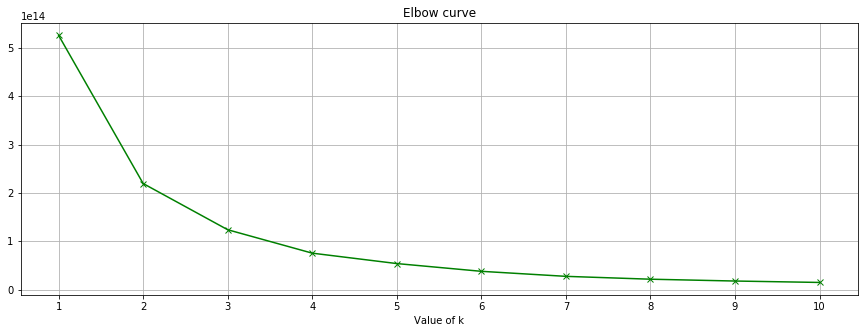

In [45]:
elbow_method(information_dataset)

The technique to determine K, the number of clusters, is called the elbow method.

Based on the elbow method which is one of the techniques for determining k We chose number of clusters **3**! 
Because as shown on the graph after k=3 the improvements are not so big if k values increases. In other words, if we add more cluster it won't be such a significant change and improvement.

That point k=3 is the optimal value for K. 

If **k=3** let's see how the kmeans clustered the data and which centroids were chosen.

In [47]:
k=3
kmeans_information_ds = KMeans(n_clusters=k,init='k-means++')
kmeans_information_ds.fit(information_dataset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
#centroids are:
kmeans_information_ds.cluster_centers_

array([[2.21033802e+05, 2.76065277e+00, 4.62876829e+02, 1.28726849e+00,
        2.03794845e+00],
       [5.12316100e+05, 3.83788774e+00, 1.24613368e+02, 1.84711965e+00,
        2.47525849e+00],
       [1.13150727e+06, 4.28779070e+00, 1.66063953e+02, 2.22093023e+00,
        2.65116279e+00]])

In [49]:
#labels assigned to each data point
labels_information_ds=kmeans_information_ds.labels_
centers_information_ds = np.array(kmeans_information_ds.cluster_centers_)

In [50]:
information_dataset.columns

Index(['price', 'locali', 'superficie', 'bagni', 'piano'], dtype='object')

In [51]:
cluster_representatives=pd.DataFrame(centers_information_ds, columns= information_dataset.columns[0:])
cluster_representatives

,price,locali,superficie,bagni,piano
0,2.210338e+05,2.760653,462.876829,1.287268,2.037948
1,5.123161e+05,3.837888,124.613368,1.847120,2.475258
2,1.131507e+06,4.287791,166.063953,2.220930,2.651163


### Visualization of k centroids for information data set

After we chose our optimal 'k' for the k-means algorithm we decided to see more detailed the way k-means clustered the data and centroid's value for each attribute of the information dataset.
On the graphs shown below it is obvious that values are different for each attribute and that k we chose is good enough to describe the data if it is clustered this way.


In [52]:
#This plot is not visible on github-->
#link to the rendered version of project->in README file and below
#http://nbviewer.jupyter.org/github/dusicastepic/ADMFourthHomework/blob/master/Clustering%20part.ipynb

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='dusica.stepic', api_key='Rx9EHvecU0SWHC02v2jo')

centers=centers_information_ds

cls=['Cluster 1','Cluster 2','Cluster 3']

trace1 = go.Scatter(x=cls, y=centers[:,0],mode = 'markers',name='Price')
trace2 = go.Scatter(x=cls, y=centers[:,1],mode = 'markers',name='Locali')
trace3 = go.Scatter(x=cls, y=centers[:,2],mode = 'markers',name='Superficie')
trace4 = go.Scatter(x=cls, y=centers[:,3],mode = 'markers',name='Bagni')
trace5 = go.Scatter(x=cls, y=centers[:,4],mode = 'markers',name='Piano')


fig = tools.make_subplots(rows=3, cols=2, subplot_titles=('Price', 'Locali',
                                                          'Superficie', 'Bagni','Piano'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)

fig['layout'].update(height=750
                     , width=1000, title='Cluster representatives' +
                                                  ' for every attribute')

py.iplot(fig, filename='make-subplots-multiple-with-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dusica.stepic/0 or inside your plot.ly account where it is named 'make-subplots-multiple-with-titles'


# Clustering Description

We start reading the csv file containing a pandas dataframe with the TF_IDF score of each word and document

In [68]:
#To load it into memory from file
description_dataset_tfidf = pd.read_csv('description_dataset_tfidf.csv', index_col=0)

In [78]:
description_dataset_tfidf.shape

(10773, 14342)

Text(0.5, 1.0, 'Elbow curve')

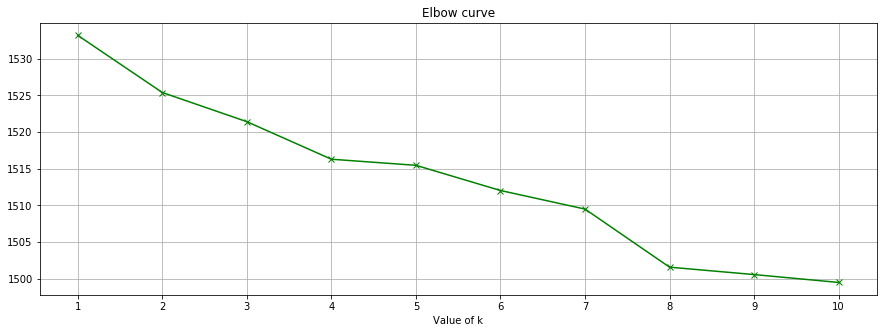

In [77]:
elbow_method(description_dataset_tfidf)

In [ ]:
k = 4 # Number of clusters
kmeans_information_ds_desc = KMeans(n_clusters=k,init='k-means++')
kmeans_information_ds_desc.fit(X)

In [82]:
# Labels assigned to each data point
labels_information_ds_desc = kmeans_information_ds_desc.labels_
centers_information_ds_desc = np.array(kmeans_desc.cluster_centers_)

In [83]:
description_dataset_tfidf.columns

Index(['giardinagg', 'moron', 'supplement', 'affascian', 'ichiest', 'fiora',
       'carmanol', 'pübblic', 'piacentin', 'uscend',
       ...
       'evolv', 'eurospin', 'term', 'floridaserviz', 'nettezz', 'imp',
       'innocenz', 'caulon', 'frizer', 'dfn'],
      dtype='object', length=14342)

## Comparison among cluster


We expect that both datasets will lead to the similar clusters. Is this true?
kmeans.labels_ returns the labels for each row od to which cluster does the row belongs to.
Based on the announcement id values we can calculate the similarity of pairs of clusters (from the information and description dataset).

In our case announcement ids are just numbers from 0 to 10772 or range(0,10773)


#jaccard_similarity should compare pairs of clusters from information and description dataset.

Using announcement id_s and cluster labels we can compare clusters among each other and calculate Jaccard similarity

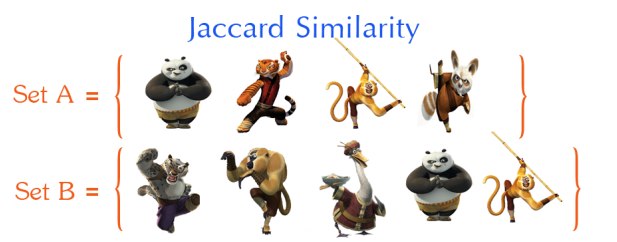

In [53]:
from IPython.display import Image
Image("jaccard_similarity.png",height=400,width=400)

**Example of Jaccard Similarity calculation**

_Jaccard Similarity formula:_

        |intersection(A,B)| / |union(A,B)|

In case above:

        jaccard_similarity = 2/7 = 0.2857

In [54]:
def jaccard_similarity(a,b):
    """
    Method that returns jaccard_similarity score: |A.intersection(B)|/|A.union(B)|
    
    input: a-predicted cluster labels for the first dataset
           b-predicted cluster labels for the second dataset
    output:
    """
    A=set(a)
    B=set(b)
    return len(A.intersection(B))/len(A.union(B))

In [55]:
#k-means labels for value of k=4 and announcement ids for description dataset
description_labels=pd.read_csv('labels_4.csv',index_col=0)

In [56]:
#making of a dictionary where keys are cluster ids(0,1,2) and values are announcement_ids which belong to that cluster
information_dict=defaultdict(list)
for i in information_dataset.index:
    information_dict[labels_information_ds[i]].append(i)

#we do the same for description dataset
description_dict=defaultdict(list)
for i in description_labels.index:
    description_dict[description_labels.loc[i][0]].append(i)

#After that we can calculate jaccard index between pairs of clusters(one from information, and one from description dataset)

#initialization of dictionary
jaccard_sim_dict={}
for info_cluster_id in information_dict.keys():
    for desc_cluster_id in description_dict.keys():
        jaccard_sim_dict[(info_cluster_id,desc_cluster_id)]=\
        jaccard_similarity(information_dict[info_cluster_id],description_dict[desc_cluster_id])
#jaccard_similarity dictionary
#(key=(label of information dataset cluster, label of description dataset cluster), value=jaccard_similarity)

In [57]:
#find 3 pairs that are most similar(have higher jaccard similarity index)
import collections
jaccard_sim_sorted=collections.Counter(jaccard_sim_dict)
top_3_jaccard_sim=jaccard_sim_sorted.most_common(3)
top_3_jaccard_sim

[((0, 0), 0.3282191158086146),
 ((0, 2), 0.26992514310876264),
 ((1, 2), 0.2295947219604147)]

Now that we have the 3-most similar couples of clusters based on the Jaccard-Similarity calculation:

We can make word clouds for each of those most similar clusters.

Every pair has the label of the cluster from the information and description dataset. Every cluster label is connected to a certain and specific announcement_id which means that based on those announcement ids we will make a new vocabulary of those words and make a new wordcloud for each.


## Word cloud of house descriptions

In order to get a wordcloud for each couple of clusters, first we need to extract the words that will be represented. Those words can be be extracted from the description of the houses that are in the relative couple.

In [58]:
top_3_jaccard_sim[0]

((0, 0), 0.3282191158086146)

In [59]:
def preprocessing_text_wordcloud(df):
    """
    Method that returns filtered words from the text input 
    
    Input: string(text)
    Output: list(bag of words)
    """  
    #for removing stop words
    stop_words = set(stopwords.words('italian')) 
    #add html tags left from scrapping
    stop_words.add('div')
    stop_words.add('n')
    stop_words.add('b')
    
    #for removing punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    
    #to tokenize the string
    word_tokens = tokenizer.tokenize(df)     

    filtered_words = [w for w in word_tokens if not w in stop_words] 
    
    #eliminate words not in vo

    return filtered_words

In [60]:
def build_vocabulary_wordcloud(df):
    """
    Method that creates smaller vocabulary for word cloud
    
    Input: dataframe
    Output: vocabulary list 
    """  
    #list for vocabulary 
    vocabulary_lst=[]
    #preprocessing description and get res->list of lists, where each list i a list of filtered preproccesed words 
    res=df.description.apply(lambda x: preprocessing_text_wordcloud(str(x)))  
    
    #vocabulary_set is a set used for making vocabulary with unique words
    res=list(res)
    vocabulary_set = set(res[0]).union(*res[1:])

    vocabulary=' '.join(vocabulary_set)
    
    return vocabulary

In [71]:
def generate_wordcloud(vocabulary_wordcloud):
    house_mask = np.array(PIL.Image.open(path.join('', "house_mask.jpg")))
    plt.rcParams['figure.figsize'] = [10, 5]

    wordcloud = WordCloud(max_font_size=45, max_words=120, background_color='white', mask=house_mask,\
    ).generate(vocabulary_wordcloud)
    plt.figure()

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

First cluster pair


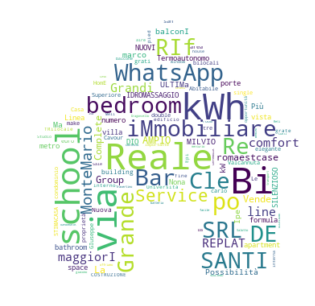

Second cluster pair


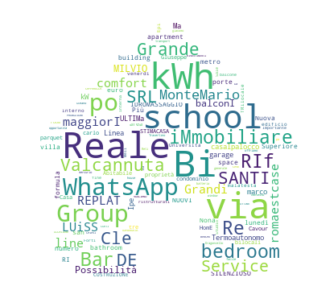

Third cluster pair


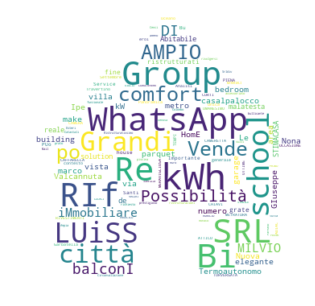

In [72]:
#method for making word clouds based on top 3 pairs
idx_lst=[idx_pair[0] for idx_pair in top_3_jaccard_sim]
title=['First cluster pair','Second cluster pair','Third cluster pair']
for idx,tup in enumerate(idx_lst): 
    x=list(set(information_dict[tup[0]]+description_dict[tup[1]]))
    df=description_dataset.loc[x]
    print(title[idx])
    generate_wordcloud(build_vocabulary_wordcloud(df))